In [1]:
from WPI_SCA_LIBRARY.CWScope import *
from WPI_SCA_LIBRARY.LeakageModels import *

## Collect Traces from the ChipWhisperer and put into three different experiments

In [2]:
# initialize scope
scope = CWScope("../WPI_SCA_LIBRARY/firmware/simpleserial-aes-CWLITEARM-SS_2_1.hex", target_type=cw.targets.SimpleSerial2)
 
# capture 1000 traces and store in an experiment named CWCapture1
scope.cw_to_file_format(1000, file_name="TestFile", experiment_name="CWCapture1", file_existing=False)

# capture 1500 traces and store in an experiment named CWCapture2
scope.cw_to_file_format(1500, file_name="TestFile", experiment_name="CWCapture2", file_existing=True)

# capture two traces sets for t-test and put into one experiment
fixed_t, rand_t = scope.capture_traces_tvla(num_traces=500)

# add t-test experiment to TestFile
file_parent = FileFormatParent("TestFile", existing=True)
file_parent.addExperiment(name="T_test", path="T_test", existing=False)

# add both datasets to file
exp = file_parent.getExperiment("T_test")

exp.createDataset("FixedTraces", "fixed", size=(500, scope.scope.adc.samples), type='float32')
fixed_data = exp.getDataset("FixedTraces")
fixed_data.addData(index=range(500), dataToAdd=fixed_t)

exp.createDataset("RandomTraces", "random", size=(500, scope.scope.adc.samples), type='float32')
random_data = exp.getDataset("RandomTraces")
random_data.addData(index=range(500), dataToAdd=rand_t)

(ChipWhisperer Other ERROR|File util.py:362) Setting unknown attribute offset in <class 'chipwhisperer.capture.scopes.OpenADC.OpenADC'>


Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6519 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6519 bytes


Capturing Fixed and Random Trace Sets: 100%|██████████| 500/500 [00:15<00:00, 31.61it/s]


## SNR
This demo shows an example of the SNR metric integrated with the file format. We use the `CWCapture2` experiment from the previous example. We use the keys and texts to create some labels for our SNR and add them as a dataset to this experiment. The user specifies the names of the label and trace datasets that they want to use, and they are parsed automatically from a the experiment in the file structure. Using the `saveGraph` arugment we are able to save the resulting plot to our file system in the same directory as the data!

Computing Signal-To-Noise Ratio: 100%|██████████| 255/255 [00:00<00:00, 9259.19it/s]


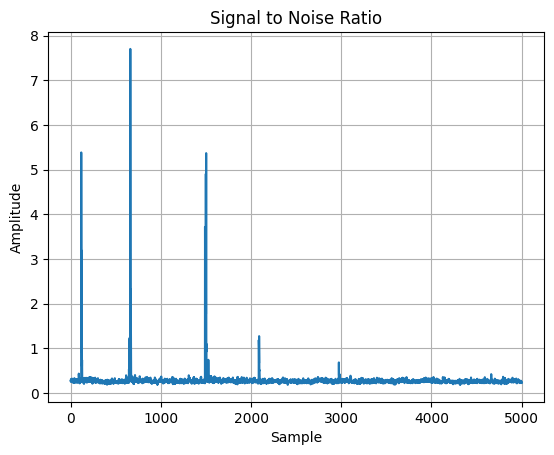

In [3]:
# read in data from CWCapture2 experiment
file = FileFormatParent("TestFile", existing=True)
experiment = file.getExperiment("CWCapture2")

keys = experiment.getDataset("CWCapture2Keys").readAll()
plaintexts = experiment.getDataset("CWCapture2Plaintexts").readAll()

# create labels for SNR
labels = Sbox[keys ^ plaintexts] 
labels = labels[:, 1]
labels = np.reshape(labels, (len(keys), 1))

# create a dataset in the CWCapture2 experiment to hold the labels 
experiment.createDataset("labelsB", "labelsB", size = (len(keys), 1), type = 'int8')
experiment.getDataset("labelsB").addData(range(len(keys)),labels)

# use integrated metric to run SNR 
test = experiment.calculateSNR("labelsB", "CWCapture2Traces", visualise=True, saveGraph=True)

## T-Test
As shown in the first code block, we collected traces and created an experiment for the t-test metric. This involved collecting power traces collected with a fixed plaintext and a random plaintext. We can load these datasets in and use our integrated t-test metric to determine and plot the result.

Calculating T-Test: 100%|██████████| 500/500 [00:00<00:00, 4361.71it/s]


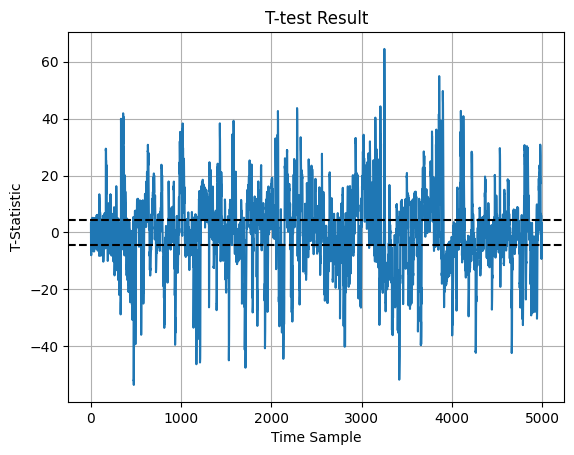

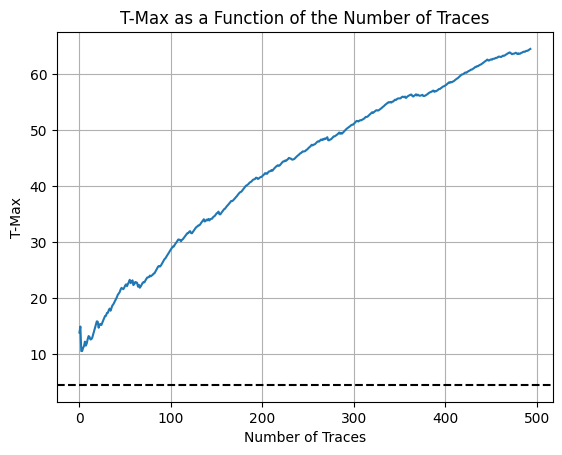

In [4]:
file = FileFormatParent("TestFile", existing=True)
experiment = file.getExperiment("T_test")
t, t_max = experiment.calculate_t_test("FixedTraces", "RandomTraces", visualize=True, save_graph=True)

## Pearson Correlation
The metrics are standalone as well. For example, we can call the correlation metric directly with numpy arrays filled with the data that we have stored in our file format. This example uses the CWCapture1 experiment. 

Correct Key: [ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]


10it [00:00, 38.71it/s]


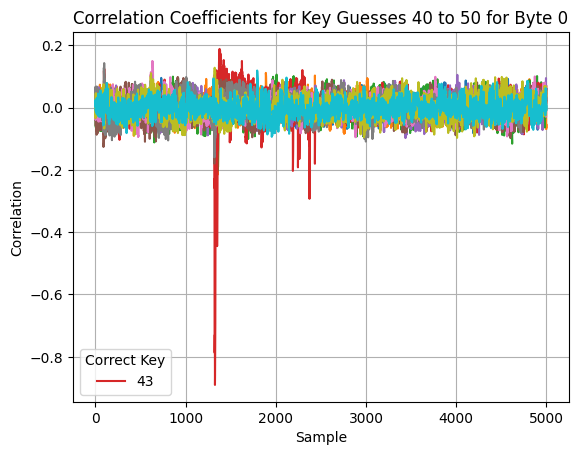

In [14]:
from WPI_SCA_LIBRARY.LeakageModels import *

file = FileFormatParent("TestFile", existing=True)
experiment = file.getExperiment("CWCapture1")

traces = experiment.getDataset("CWCapture1Traces").readAll()
keys = experiment.getDataset("CWCapture1Keys").readAll()
print("Correct Key: {}".format(keys[0]))
plaintexts = experiment.getDataset("CWCapture1Plaintexts").readAll()

for j, k in tqdm.tqdm(enumerate(range(40, 50))):
    leakage = leakage_model_hamming_weight(num_traces=1000, plaintexts=plaintexts, subkey_guess=k, target_byte=0)
    correlation = pearson_correlation(leakage, traces)
    if k == 43:
        plt.plot(correlation, label=k)
    else:
        plt.plot(correlation)

plt.legend(title="Correct Key")
plt.title("Correlation Coefficients for Key Guesses 40 to 50 for Byte 0")
plt.xlabel("Sample")
plt.ylabel("Correlation")
plt.grid()
plt.show()

## Score and Rank
We know that from the correlation example, byte 0 of the key used to encrypt the traces in the CWCapture1 experiment is likely equal to 43. The idea behind score and rank is that each key guess of a subkey is scored and the highest scores are ranked first. We can run our score and rank metric on the CWCapture1 experiment and see if it ranks k = 43 the highest.

In [4]:
from WPI_SCA_LIBRARY.LeakageModels import *

file = FileFormatParent("TestFile", existing=True)
experiment = file.getExperiment("CWCapture1")
traces = experiment.getDataset("CWCapture1Traces").readAll()
plaintexts = experiment.getDataset("CWCapture1Plaintexts").readAll()

key_ranks = np.empty(256, dtype=object)
key_scores = np.empty(256, dtype=object)
key_candidates = range(256)

ranks_scores = score_and_rank(key_candidates, 0, traces, score_with_correlation, plaintexts, leakage_model_hamming_weight)

print("Highest Ranked Key Guess: {} with score {}".format(ranks_scores[0][0], ranks_scores[0][1]))

Highest Ranked Key Guess: 43 with score 0.8901868193821935
